# 単位円盤上のPoisson方程式

MathWorkの以下の[問題](https://jp.mathworks.com/help/pde/ug/solve-poissons-equation-on-a-unit-disk.html)が面白そうだったのでGetFEM++で解いてみます。円盤の半径は0.5で、円盤内ではPoisson方程式が成り立っているとします。円の境界にはDirichlet条件が設けられています。(画像はMathWorksより引用)
![Geometory](https://jp.mathworks.com/help/examples/pde/win64/pdedemo1_01.png)

In [25]:
import getfem as gf

In [26]:
mo = gf.MesherObject('ball', [1.0, 1.0], 1.0)

In [27]:
h = 0.05
mesh = gf.Mesh('generate', mo, h, 2)
mesh.translate([-1.0, -1.0])

In [28]:
fb = mesh.outer_faces()
OUTER_BOUND = 1
mesh.set_region(OUTER_BOUND, fb)

Notebook initialized with x3d backend.


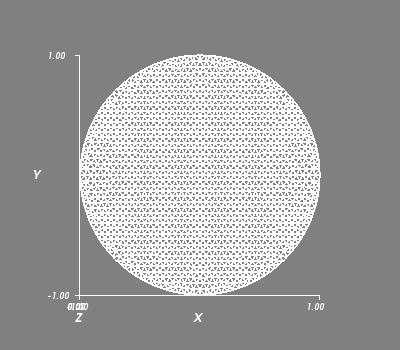

In [29]:
filename = 'mesh.vtk'
mesh.export_to_vtk(filename, 'ascii')

from mayavi import mlab
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(filename)
extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
surface = mlab.pipeline.surface(extract_edges)
axes = mlab.axes(surface)

picturename = 'mesh.png'
mlab.show()
mlab.savefig(picturename)
mlab.clf()
from IPython.display import Image, display_png
display_png(Image(picturename))

メッシュが作成できました。次にメッシュに有限要素法を設定します。今回は通常のLagrange要素を使用します。節点の自由度は1、要素次数は2とします。

In [30]:
mfu = gf.MeshFem(mesh, 1)

In [31]:
elements_degree = 2
mfu.set_classical_fem(elements_degree)

MeshFEMオブジェクトの用意ができましたので、Modelオブジェクトを作成します。変数uとしてmfuを設定します。

次に円$\Omega$上で以下の微分方程式を仮定します。
$$
-\Delta u = 1, u \subset \Omega
$$

In [32]:
md = gf.Model('real')
md.add_fem_variable('u', mfu)
md.add_fem_data('F', mfu)
mim = gf.MeshIm(mesh, pow(elements_degree,2))

In [33]:
md.add_Laplacian_brick(mim, 'u')
md.add_source_term_brick(mim, 'u', 'F')

1

In [34]:
import numpy as np
md.set_variable('F', np.repeat(1.0, mfu.nbdof()))

In [35]:
md.add_Dirichlet_condition_with_multipliers(mim, 'u', elements_degree - 1, OUTER_BOUND)

2

In [36]:
md.solve()

(0, 1)

In [37]:
U = md.variable('u')

In [38]:
vtkfilename = 'displacement.vtk'
mfu.export_to_vtk(vtkfilename, mfu, U, 'Displacement')

Notebook initialized with x3d backend.


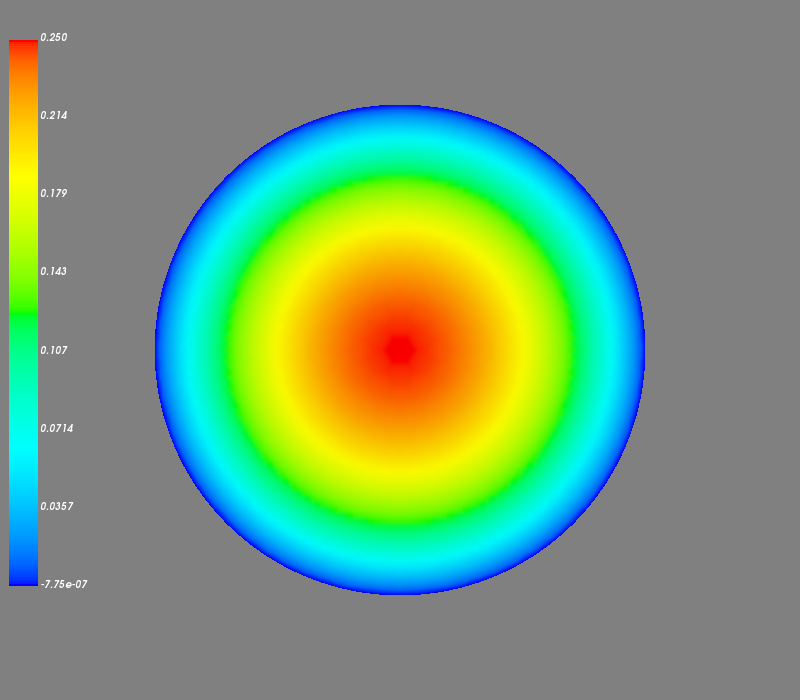

In [39]:
# mayavi2 -d displacement_with_von_mises1.vtk -f WarpVector -m Surface -d displacement_with_von_mises2.vtk -f WarpVector -m Surface
from mayavi import mlab

filename = 'solutions.png'

#%gui qt
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(vtkfilename)
surface = mlab.pipeline.surface(vtk_file_reader)

mlab.scalarbar(orientation='vertical')
mlab.show()
mlab.savefig(filename, magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image(filename))

理論解は次式で表されます。
$$
u(x, y) = \dfrac{1-x^2-y^2}{4}
$$

In [40]:
xy = mfu.basic_dof_nodes()
x = xy[0, :]
y = xy[1, :]

In [41]:
sol = (1-x*x-y*y)/4.0

In [42]:
vtkfilename = 'sol.vtk'
mfu.export_to_vtk(vtkfilename, mfu, sol, 'solution')

Notebook initialized with x3d backend.


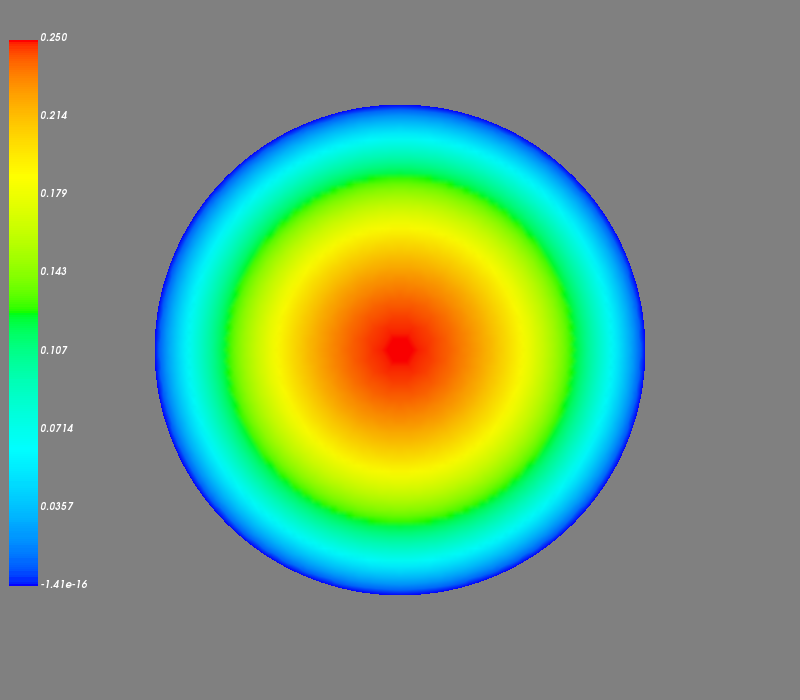

In [43]:
# mayavi2 -d displacement_with_von_mises1.vtk -f WarpVector -m Surface -d displacement_with_von_mises2.vtk -f WarpVector -m Surface
from mayavi import mlab

filename = 'solutions.png'

#%gui qt
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(vtkfilename)
surface = mlab.pipeline.surface(vtk_file_reader)

mlab.scalarbar(orientation='vertical')
mlab.show()
mlab.savefig(filename, magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image(filename))

In [44]:
vtkfilename = 'error.vtk'
mfu.export_to_vtk(vtkfilename, mfu, U-sol, 'error')

Notebook initialized with x3d backend.


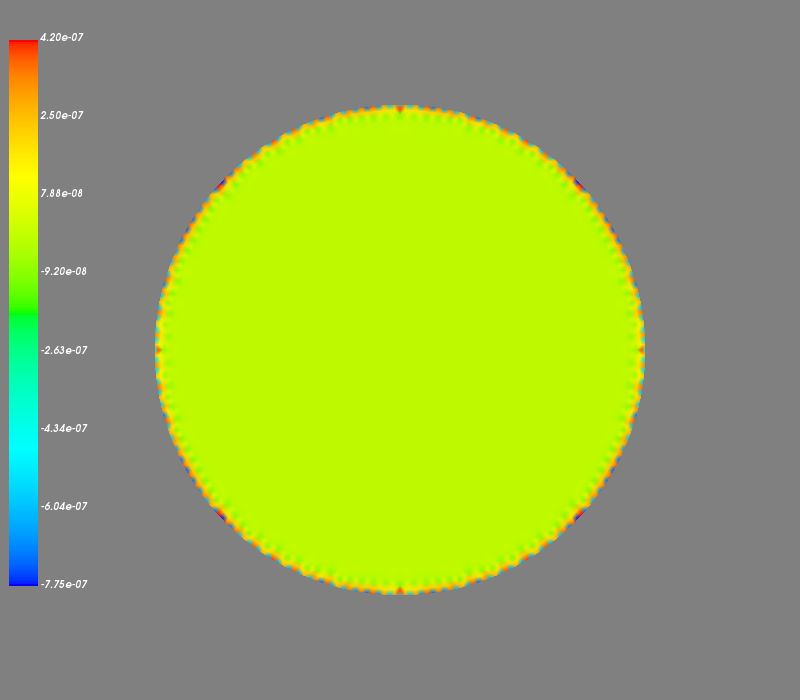

In [45]:
# mayavi2 -d displacement_with_von_mises1.vtk -f WarpVector -m Surface -d displacement_with_von_mises2.vtk -f WarpVector -m Surface
from mayavi import mlab

filename = 'solutions.png'

#%gui qt
mlab.init_notebook()
vtk_file_reader = mlab.pipeline.open(vtkfilename)
surface = mlab.pipeline.surface(vtk_file_reader)

mlab.scalarbar(orientation='vertical')
mlab.show()
mlab.savefig(filename, magnification=2)
mlab.clf()

from IPython.display import Image, display_png
display_png(Image(filename))